We start by importing a few standard packages that we always use

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2023.09.6


In [2]:
# Use Schrodinger's open-source coordgen library as our default engine 
# for creating molecular coordinates
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

# Reading molecules

Probably the most fundamental type to understand when using the RDKit is the molecule type.

Let's start with how to create new molecules.

In [3]:
doravirine = Chem.MolFromMolFile('./data/doravirine.mol')

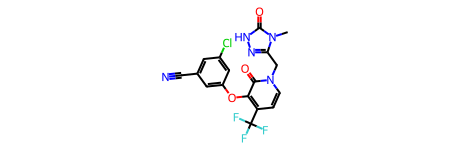

In [4]:
doravirine

When the last entry in a notebook cell is an RDKit molecule, the RDKit shows you an image of the molecule.

Here's the actual type:

In [5]:
type(doravirine)

rdkit.Chem.rdchem.Mol

We can also create molecules from SMILES:

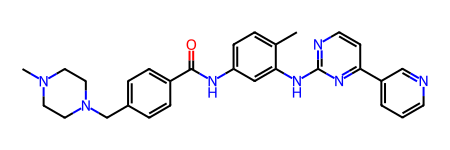

In [6]:
imatinib = Chem.MolFromSmiles('Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1')
imatinib

Before moving on, it makes sense to take a look at how errors are handled:

In [7]:
m = Chem.MolFromSmiles('CCO(CC)CC')

[09:14:30] Explicit valence for atom # 2 O, 3, is greater than permitted


In [8]:
m is None

True

It is possible to disable sanitization, but you get back a molecule which may have terrible chemistry problems and which is certainly missing a lot of useful calculated properties.

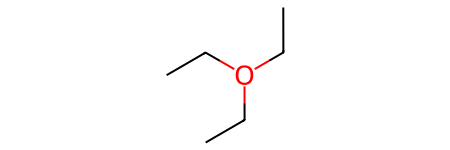

In [9]:
m = Chem.MolFromSmiles('CCO(CC)CC',sanitize=False)
m

Or we can read sets of molecules using a supplier.

In [10]:
!head ./data/zinc_bbs.small.smi

In [11]:
suppl = Chem.SmilesMolSupplier('./data/zinc_bbs.small.smi',delimiter=',')
bbs = [x for x in suppl if x is not None]  #<- notice that we are filtering out molecules which have sanitization problems
len(bbs)

5000

In [12]:
bbs

 ...]

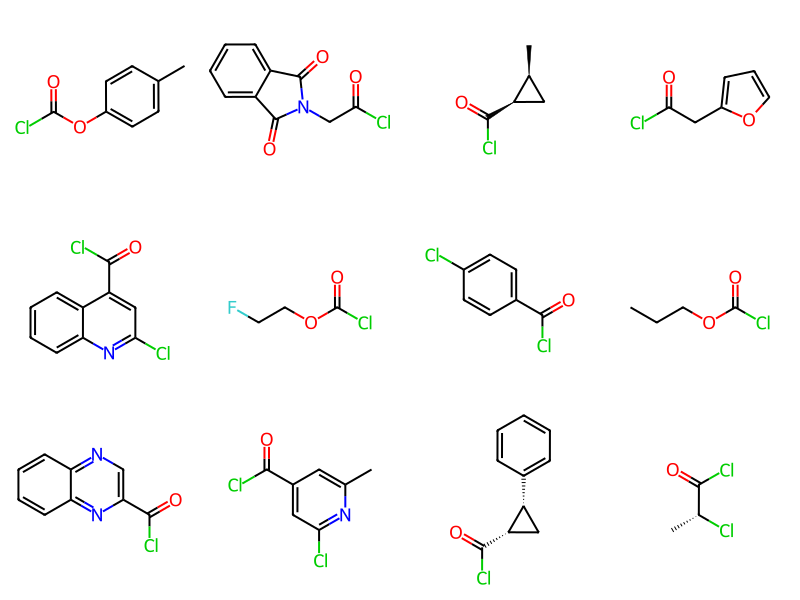

In [13]:
Draw.MolsToGridImage(bbs[:12],molsPerRow=4)

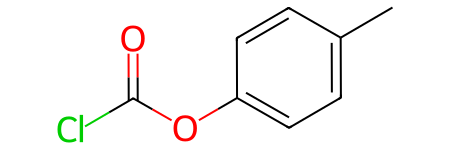

In [14]:
bb = bbs[0]
bb

In [15]:
bb.GetPropsAsDict()

{'SlogP': 2.7326200000000007,
 'TPSA': 26.3,
 'AMW': 170.59500000000003,
 'NumRotatableBonds': 1,
 'NumHBD': 0,
 'NumHBA': 2,
 'NumHeavyAtoms': 11,
 'NumStereocenters': 0,
 'NumUnspecifiedStereocenters': 0}

In [16]:
bb.GetProp('NumHBD'),bb.GetIntProp('NumHBD')

('0', 0)

In [17]:
bb.GetDoubleProp('AMW')

170.59500000000003

In [18]:
bb.GetIntProp('AMW')

ValueError: key `AMW` exists but does not result in an integer value reason: bad any_cast

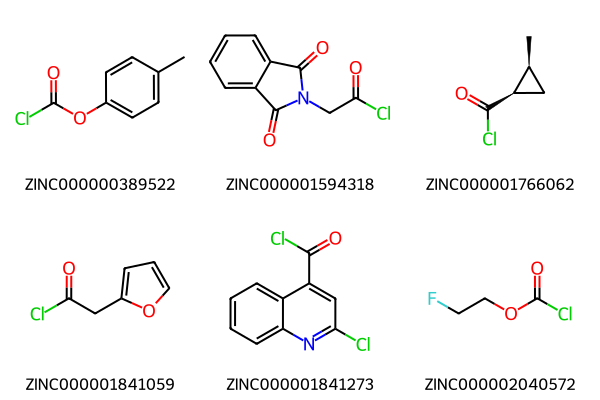

In [19]:
Draw.MolsToGridImage(bbs[:6],legends=[x.GetProp('_Name') for x in bbs])

## Good to know: molecule data in images

By default the RDKit saves information about molecules in metadata in PNGs it produces.

This means that you can recreate molecule(s) directly from the PNGs:

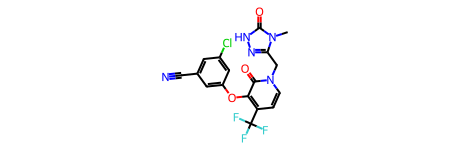

In [20]:
doravirine

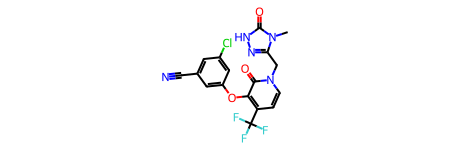

In [21]:
m = Chem.MolFromPNGFile('/tmp/mol.png')
m

In [22]:
mols = Chem.MolsFromPNGFile('/tmp/grid.png')
len(mols)

6

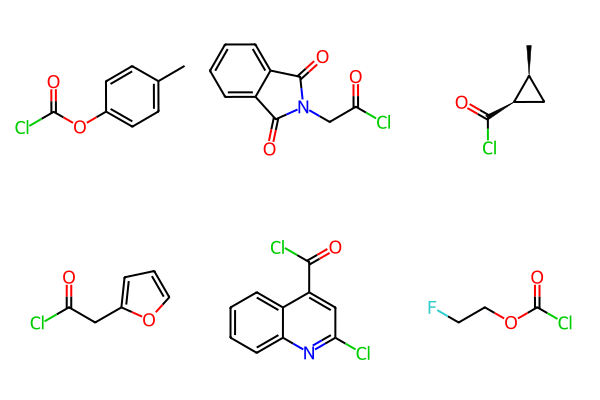

In [23]:
Draw.MolsToGridImage(mols)

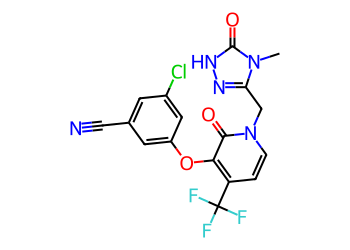

In [24]:
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
from io import BytesIO

d2d = rdMolDraw2D.MolDraw2DCairo(350,250)
d2d.DrawMolecule(doravirine)
d2d.FinishDrawing()
png = d2d.GetDrawingText()

sio = BytesIO()
sio.write(png)

img = Image.open(sio)
img


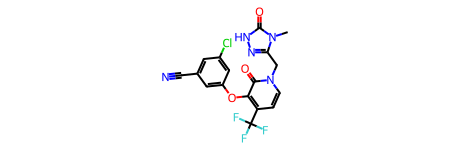

In [25]:
m = Chem.MolFromPNGString(png)
m

SVGs can also store metadata, but it requires an extra step

In [26]:
d2d = rdMolDraw2D.MolDraw2DSVG(350,250)
d2d.DrawMolecule(doravirine)
d2d.AddMoleculeMetadata(doravirine)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()


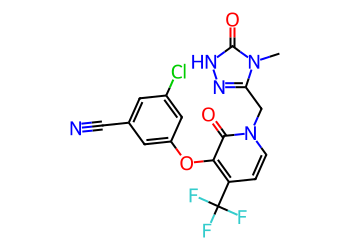

In [27]:
from IPython.display import SVG
SVG(svg)

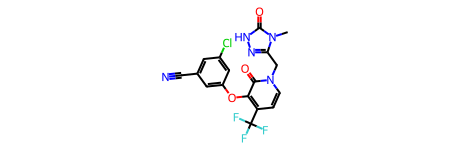

In [28]:
m = Chem.MolFromRDKitSVG(svg)
m

In [29]:
print(svg)

<?xml version='1.0' encoding='iso-8859-1'?>
<svg version='1.1' baseProfile='full'
              xmlns='http://www.w3.org/2000/svg'
                      xmlns:rdkit='http://www.rdkit.org/xml'
                      xmlns:xlink='http://www.w3.org/1999/xlink'
                  xml:space='preserve'
width='350px' height='250px' viewBox='0 0 350 250'>
<!-- END OF HEADER -->
<rect style='opacity:1.0;fill:#FFFFFF;stroke:none' width='350.0' height='250.0' x='0.0' y='0.0'> </rect>
<path class='bond-0 atom-0 atom-1' d='M 181.9,117.1 L 166.2,95.5' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />
<path class='bond-0 atom-0 atom-1' d='M 177.3,117.6 L 164.3,99.8' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />
<path class='bond-1 atom-0 atom-2' d='M 181.9,117.1 L 171.0,141.5' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-widt

# Basic molecule manipulations

By default molecules do not have explicit hydrogens in the graph and any explicit Hs in the input are removed.

In [30]:
m = Chem.MolFromSmiles('CO')
m.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP3
Bonds:
	0 0->1 order: 1


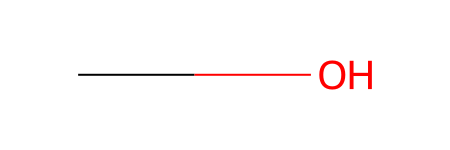

In [31]:
m

In [32]:

mb = '''
  Mrv2102 10182112293D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 6 5 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C 1.41 0.0013 0.0022 0
M  V30 2 O -0.0111 -0.0097 -0.0168 0
M  V30 3 H 1.7704 1.03 0.0043 0
M  V30 4 H 1.7817 -0.5105 -0.8842 0
M  V30 5 H 1.7704 -0.5112 0.8942 0
M  V30 6 H -0.2781 0.4621 0.8004 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 1 1 3
M  V30 3 1 1 4
M  V30 4 1 1 5
M  V30 5 1 2 6
M  V30 END BOND
M  V30 END CTAB
M  END
'''
m = Chem.MolFromMolBlock(mb)
m.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 4 imp: 0 hyb: SP3
	1 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP3
Bonds:
	0 0->1 order: 1


The removal of Hs can be turned off (often relevant when working with 3D structures):

In [33]:
m2 = Chem.MolFromMolBlock(mb,removeHs=False)
m2.Debug()

Atoms:
	0 6 C chg: 0  deg: 4 exp: 4 imp: 0 hyb: SP3
	1 8 O chg: 0  deg: 2 exp: 2 imp: 0 hyb: SP3
	2 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
	3 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
	4 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
	5 1 H chg: 0  deg: 1 exp: 1 imp: 0 hyb: S
Bonds:
	0 0->1 order: 1
	1 0->2 order: 1
	2 0->3 order: 1
	3 0->4 order: 1
	4 1->5 order: 1


We can always add Hs to/remove Hs from a molecule:

In [34]:
mh = Chem.AddHs(m)
m3 = Chem.RemoveHs(mh)
m.GetNumAtoms(),mh.GetNumAtoms(),m3.GetNumAtoms()

(2, 6, 2)

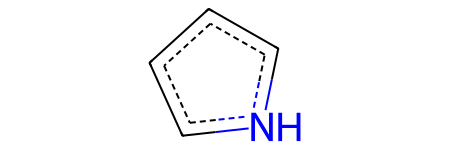

In [35]:
IPythonConsole.kekulizeStructures = False
pyr = Chem.MolFromSmiles('C1=CNC=C1')
pyr

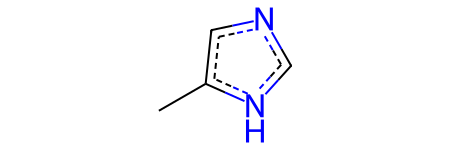

In [36]:
pyr = Chem.MolFromSmiles('c1[nH]c(C)cn1')
pyr


In [37]:
pyr = Chem.MolFromSmiles('c1nc(C)cn1')
pyr


[09:15:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5


In [38]:
IPythonConsole.kekulizeStructures = True


# Writing molecules

In [39]:
Chem.MolToSmiles(bb)

'Cc1ccc(OC(=O)Cl)cc1'

In [40]:
bbc = Chem.Mol(bb)
Chem.MolToSmiles(bbc,kekuleSmiles=True)

'CC1=CC=C(OC(=O)Cl)C=C1'

In [41]:
Chem.MolToSmiles(bbc,canonical=False)

'Cc1ccc(OC(=O)Cl)cc1'

In [42]:
print(Chem.MolToMolBlock(bb))

ZINC000000389522
     RDKit          2D

 11 11  0  0  0  0  0  0  0  0999 V2000
    2.5153    1.1000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.6511    0.5968    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.6547   -0.4030    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7905   -0.9062    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0773   -0.4094    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.9415   -0.9124    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8093   -0.4156    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8129    0.5844    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -2.6735   -0.9186    0.0000 Cl  0  0  0  0  0  0  0  0  0  0  0  0
   -0.0809    0.5906    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7833    1.0938    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  2  0
  3  4  1  0
  4  5  2  0
  5  6  1  0
  6  7  1  0
  7  8  2  0
  7  9  1  0
  5 10  1  0
 10 11  2  0
 11  2  1  0
M  END

In [43]:
print(Chem.MolToV3KMolBlock(bb))

ZINC000000389522
     RDKit          2D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 11 11 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C 2.515345 1.099964 0.000000 0
M  V30 2 C 1.651145 0.596764 0.000000 0
M  V30 3 C 1.654745 -0.403036 0.000000 0
M  V30 4 C 0.790545 -0.906236 0.000000 0
M  V30 5 C -0.077255 -0.409436 0.000000 0
M  V30 6 O -0.941455 -0.912436 0.000000 0
M  V30 7 C -1.809254 -0.415636 0.000000 0
M  V30 8 O -1.812855 0.584364 0.000000 0
M  V30 9 Cl -2.673455 -0.918636 0.000000 0
M  V30 10 C -0.080855 0.590564 0.000000 0
M  V30 11 C 0.783345 1.093764 0.000000 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 1 6 7
M  V30 7 2 7 8
M  V30 8 1 7 9
M  V30 9 1 5 10
M  V30 10 2 10 11
M  V30 11 1 11 2
M  V30 END BOND
M  V30 END CTAB
M  END



In [44]:
with Chem.SDWriter('./data/output.sdf',) as w:
    w.SetForceV3000(True)
    for m in bbs[:5]:
        w.write(m)
!grep -2 TPSA ./data/output.sdf

2.7326200000000007

>  <TPSA>  (1) 
26.3

--
1.048

>  <TPSA>  (2) 
54.45

--
1.4078

>  <TPSA>  (3) 
17.07

--
1.5875

>  <TPSA>  (4) 
30.21

--
3.2672000000000008

>  <TPSA>  (5) 
29.96



## An aside for people building SMILES-based AI models

In [45]:
Chem.MolToRandomSmilesVect(bb,10,randomSeed=0xf00d)

['c1c(ccc(c1)C)OC(=O)Cl',
 'c1(ccc(cc1)OC(=O)Cl)C',
 'c1(C)ccc(cc1)OC(=O)Cl',
 'c1c(ccc(C)c1)OC(=O)Cl',
 'c1c(ccc(OC(=O)Cl)c1)C',
 'c1c(ccc(OC(Cl)=O)c1)C',
 'c1cc(ccc1C)OC(Cl)=O',
 'c1cc(OC(Cl)=O)ccc1C',
 'c1cc(ccc1OC(=O)Cl)C',
 'O=C(Cl)Oc1ccc(C)cc1']

# Working with pandas

In [46]:
len(bbs)

5000

/home/glandrum/mambaforge/envs/py311_2024AICHEMIST/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:137: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,SlogP,TPSA,AMW,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumStereocenters,NumUnspecifiedStereocenters,ID,ROMol
0,2.7326200000000007,26.3,170.59500000000003,1,0,2,11,0,0,ZINC000000389522,
1,1.048,54.45,223.615,2,0,3,15,0,0,ZINC000001594318,
2,1.4078,17.07,118.563,1,0,1,7,2,0,ZINC000001766062,
3,1.5875,30.21,144.557,2,0,2,9,0,0,ZINC000001841059,
4,3.2672000000000008,29.96,226.062,1,0,2,14,0,0,ZINC000001841273,

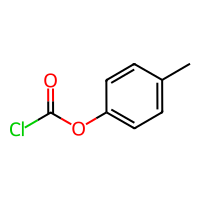
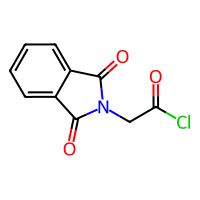
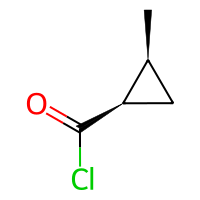
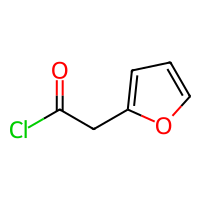
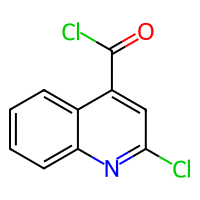

In [47]:
import pandas as pd
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(True)

df = PandasTools.LoadSDF('./data/output.sdf')
df.head()

In [48]:
df = pd.read_csv('./data/zinc_bbs.small.smi')
df.head()

/home/glandrum/mambaforge/envs/py311_2024AICHEMIST/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:137: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,smiles,zinc_id,SlogP,TPSA,AMW,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumStereocenters,NumUnspecifiedStereocenters
0,Cc1ccc(OC(=O)Cl)cc1,ZINC000000389522,2.73262,26.30,170.595,1,0,2,11,0,0
1,O=C(Cl)CN1C(=O)c2ccccc2C1=O,ZINC000001594318,1.04800,54.45,223.615,2,0,3,15,0,0
2,C[C@H]1C[C@H]1C(=O)Cl,ZINC000001766062,1.40780,17.07,118.563,1,0,1,7,2,0
3,O=C(Cl)Cc1ccco1,ZINC000001841059,1.58750,30.21,144.557,2,0,2,9,0,0
4,O=C(Cl)c1cc(Cl)nc2ccccc12,ZINC000001841273,3.26720,29.96,226.062,1,0,2,14,0,0


/home/glandrum/mambaforge/envs/py311_2024AICHEMIST/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:137: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,smiles,zinc_id,SlogP,TPSA,AMW,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumStereocenters,NumUnspecifiedStereocenters,ROMol
0,Cc1ccc(OC(=O)Cl)cc1,ZINC000000389522,2.73262,26.30,170.595,1,0,2,11,0,0,
1,O=C(Cl)CN1C(=O)c2ccccc2C1=O,ZINC000001594318,1.04800,54.45,223.615,2,0,3,15,0,0,
2,C[C@H]1C[C@H]1C(=O)Cl,ZINC000001766062,1.40780,17.07,118.563,1,0,1,7,2,0,
3,O=C(Cl)Cc1ccco1,ZINC000001841059,1.58750,30.21,144.557,2,0,2,9,0,0,
4,O=C(Cl)c1cc(Cl)nc2ccccc12,ZINC000001841273,3.26720,29.96,226.062,1,0,2,14,0,0,

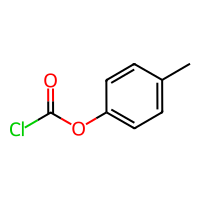
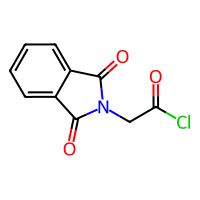
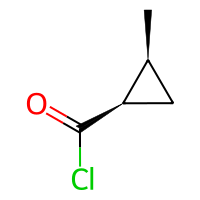
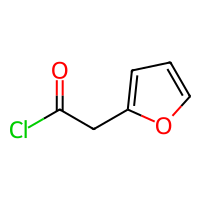
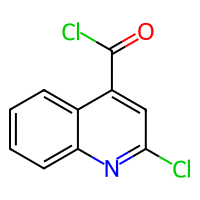

In [49]:
PandasTools.AddMoleculeColumnToFrame(df,smilesCol='smiles')
df.head()

/home/glandrum/mambaforge/envs/py311_2024AICHEMIST/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:137: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,smiles,zinc_id,SlogP,TPSA,AMW,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumStereocenters,NumUnspecifiedStereocenters,ROMol
46,COC(=O)c1cccc(C(=O)Cl)n1,ZINC000045792709,1.24720,56.26,199.593,2,0,4,13,0,0,
51,O=C(O)c1ccccc1O,ZINC000000001554,1.09040,57.53,138.122,1,2,2,10,0,0,
52,C[C@H]1C[C@@H](C)CN(S(=O)(=O)c2ccc(Cl)c(C(=O)O...,ZINC000000002163,2.70480,74.68,331.821,3,1,3,21,2,0,
54,O=C(O)c1ccc(O)c(O)c1,ZINC000000013246,0.79600,77.76,154.121,1,3,3,11,0,0,
55,Cc1cccc(Nc2ccccc2C(=O)O)c1C,ZINC000000020241,3.74524,49.33,241.290,3,2,2,18,0,0,

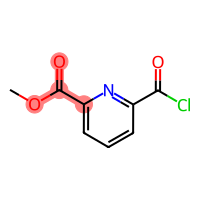
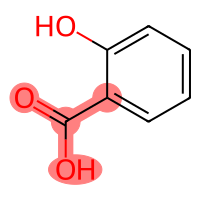
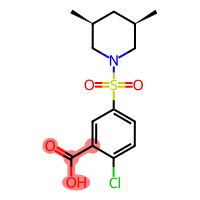
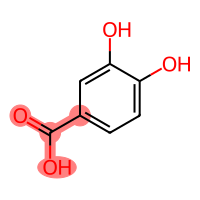
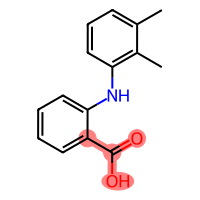

In [50]:
qry = Chem.MolFromSmarts('cC(=O)[O]')
aromatic_acids = df[df.ROMol >= qry]
aromatic_acids.head()

In [51]:
PandasTools.WriteSDF(aromatic_acids,'/tmp/blah.sdf')

In [52]:
!head -50 /tmp/blah.sdf


     RDKit          2D

 13 13  0  0  0  0  0  0  0  0999 V2000
   -3.1961    0.3960    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.3319   -0.1070    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4641    0.3898    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4605    1.3898    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6001   -0.1132    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6035   -1.1132    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2607   -1.6164    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.1285   -1.1194    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.1321   -0.1196    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.9999    0.3774    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0035    1.3774    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.8641   -0.1258    0.0000 Cl  0  0  0  0  0  0  0  0  0  0  0  0
    0.2679    0.3836    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0

Write the properties too:

In [53]:
PandasTools.WriteSDF(aromatic_acids,'/tmp/blah.sdf',properties=list(aromatic_acids.columns))

In [54]:
!head -50 /tmp/blah.sdf


     RDKit          2D

 13 13  0  0  0  0  0  0  0  0999 V2000
   -3.1961    0.3960    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.3319   -0.1070    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4641    0.3898    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4605    1.3898    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6001   -0.1132    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6035   -1.1132    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2607   -1.6164    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.1285   -1.1194    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.1321   -0.1196    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.9999    0.3774    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0035    1.3774    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.8641   -0.1258    0.0000 Cl  0  0  0  0  0  0  0  0  0  0  0  0
    0.2679    0.3836    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0

# Calculated properties

In [55]:
from rdkit.Chem import Descriptors

descrs = Descriptors.CalcMolDescriptors(bbs[0])
descrs

{'MaxAbsEStateIndex': 10.241289525069288,
 'MaxEStateIndex': 10.241289525069288,
 'MinAbsEStateIndex': 0.46814814814814865,
 'MinEStateIndex': -0.8112471655328795,
 'qed': 0.606163561640066,
 'SPS': 9.272727272727273,
 'MolWt': 170.59500000000003,
 'HeavyAtomMolWt': 163.539,
 'ExactMolWt': 170.013457144,
 'NumValenceElectrons': 58,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.4086910148177083,
 'MinPartialCharge': -0.4145025333091847,
 'MaxAbsPartialCharge': 0.4145025333091847,
 'MinAbsPartialCharge': 0.4086910148177083,
 'FpDensityMorgan1': 1.3636363636363635,
 'FpDensityMorgan2': 1.9090909090909092,
 'FpDensityMorgan3': 2.3636363636363638,
 'BCUT2D_MWHI': 35.495729188004034,
 'BCUT2D_MWLOW': 10.224929415580378,
 'BCUT2D_CHGHI': 1.9672872130523908,
 'BCUT2D_CHGLO': -1.9771631089693287,
 'BCUT2D_LOGPHI': 2.1161340922896006,
 'BCUT2D_LOGPLOW': -1.9469584714192045,
 'BCUT2D_MRHI': 6.6100755655163885,
 'BCUT2D_MRLOW': 0.22542912840754678,
 'AvgIpc': 1.9291266251851134,
 'BalabanJ': 2

The full list of 2D descriptors, with references, is here: https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors

# Going 3D

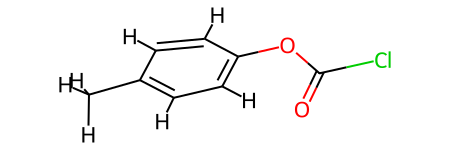

In [56]:
from rdkit.Chem import rdDistGeom

mh = Chem.AddHs(bbs[0])

params = rdDistGeom.ETKDGv3()
params.randomSeed = 0xc0ffee

rdDistGeom.EmbedMolecule(mh,params)
mh

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

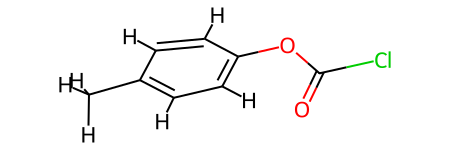

In [57]:
IPythonConsole.ipython_3d = True
mh

The conformers that come from ETKDG are reasonable starting points, but you can clean them up with a force field if you want:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

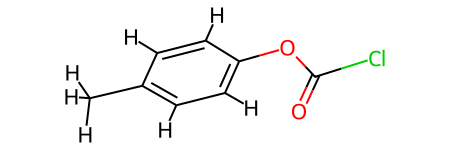

In [58]:
from rdkit.Chem import rdForceFieldHelpers
rdForceFieldHelpers.MMFFOptimizeMolecule(mh)
mh

In [59]:
from rdkit.Chem import Descriptors3D
descrs = Descriptors3D.CalcMolDescriptors3D(mh)
descrs

{'PMI1': 147.93654004932614,
 'PMI2': 1210.584339714454,
 'PMI3': 1244.5360134588248,
 'NPR1': 0.11886883019012016,
 'NPR2': 0.9727194123936904,
 'RadiusOfGyration': 2.7621272547709332,
 'InertialShapeFactor': 0.00657524781956749,
 'Eccentricity': 0.9929099663157946,
 'Asphericity': 0.6885879899944947,
 'SpherocityIndex': 0.12609313422243157,
 'PBF': 0.4262677768656932}

There are also some vector-quantity 3D descriptors:

In [60]:
from rdkit.Chem import rdMolDescriptors
rdMolDescriptors.CalcAUTOCORR3D(mh)

[0.152,
 0.414,
 0.637,
 0.83,
 0.739,
 0.393,
 0.228,
 0.296,
 0.0,
 0.0,
 0.137,
 0.36,
 0.341,
 0.402,
 0.426,
 0.254,
 0.221,
 0.056,
 0.0,
 0.0,
 0.109,
 0.243,
 0.317,
 0.326,
 0.273,
 0.172,
 0.122,
 0.072,
 0.0,
 0.0,
 0.161,
 0.446,
 0.65,
 0.843,
 0.774,
 0.478,
 0.247,
 0.361,
 0.0,
 0.0,
 0.11,
 0.244,
 0.345,
 0.373,
 0.309,
 0.184,
 0.135,
 0.101,
 0.0,
 0.0,
 0.17,
 0.489,
 0.754,
 1.041,
 0.97,
 0.527,
 0.272,
 0.421,
 0.0,
 0.0,
 0.606,
 2.157,
 2.038,
 2.681,
 2.896,
 2.054,
 1.221,
 1.591,
 0.0,
 0.0,
 0.123,
 0.291,
 0.391,
 0.433,
 0.379,
 0.242,
 0.161,
 0.137,
 0.0,
 0.0]

The full list of 3D descriptors, with references, is here:
https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-3d-descriptors

# Working with molecular data sets

I will demo this using the datasets from this paper:
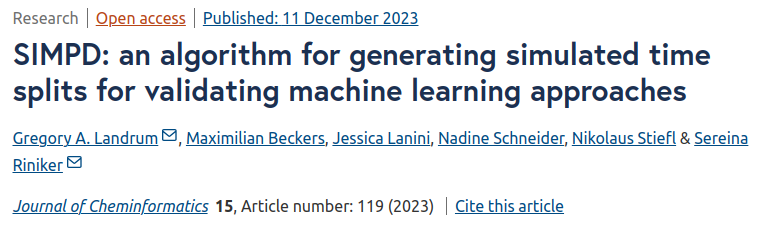

https://jcheminf.biomedcentral.com/articles/10.1186/s13321-023-00787-9

on github:
https://github.com/rinikerlab/molecular_time_series

One really convenient way to work with collections of molecular data sets is to use the RDKit' integration with [`intake`](https://intake.readthedocs.io/en/stable/index.html): https://github.com/greglandrum/intake-rdkit

To install:
```
python -m pip install git+https://github.com/greglandrum/intake-rdkit.git
```

In [61]:
import intake
catalog = intake.open_catalog('/home/glandrum/Code/molecular_time_series/datasets/chemblKi_SIMPD.yaml')
catalog.metadata

{'version': 1,
 'creator': {'name': 'greg landrum', 'email': 'glandrum@ethz.ch'},
 'summary': "Collection of datasets with pchembl_values for bioactivity prediction.\n\nEach row includes the reported value. Only values without data_validity_comments are included\nActive/inactive class assignments were done to give a 40/60 inactive/active ratio\nThe suggested train/test split was created using the SIMPD algorithm\nAll compounds have been salt stripped and neutralized using the RDKit's ChargeParent standardizer\n",
 'split_column': 'split',
 'class_column': 'active',
 'activity_column': 'standard_value'}

In [62]:
catalog['CHEMBL1800-1'].metadata

{'url': 'https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL1800/',
 'source': 'ChEMBL_32',
 'organism': 'Homo sapiens',
 'assay_organism': 'Homo sapiens',
 'assay_bao_format': 'BAO_0000219',
 'activity_type': 'Ki',
 'min pchembl_value': 4.26,
 'max pchembl_value': 9.7,
 'median pchembl_value': 7.55,
 'is_log_data': True,
 'activity bin': 7.9,
 'Compounds': 518,
 'Num Active': 198,
 'Num Inactive': 320,
 'catalog_dir': '/home/glandrum/Code/molecular_time_series/datasets/'}

/home/glandrum/mambaforge/envs/py311_2024AICHEMIST/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:137: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,mol,canonical_smiles,compound_chembl_id,pchembl_value,active,split
0,,CCN(Cc1ccccc1)Cc1sc(Nc2c(Cl)cc(Cl)cc2Cl)nc1C(F...,CHEMBL180880,6.92,0,train
1,,CCCCC(c1ccc(F)cc1)N(CCC)c1nc(-c2ccc(Cl)cc2OC)n...,CHEMBL362453,8.14,1,train
2,,CCCC(CCC)N1CCc2cn(-c3ccc(Cl)cc3C#N)c3nc(C)cc1c23,CHEMBL370501,7.89,0,train
3,,Cc1cc2c3c(n1)c(-c1ccc(Cl)cc1Cl)nn3C[C@H](C)N2C...,CHEMBL196307,8.10,1,train
4,,FC(F)(F)CCN(Cc1ccc(Cl)cc1)Cc1sc(Nc2c(Cl)cc(Cl)...,CHEMBL181134,8.49,1,train

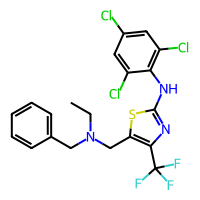
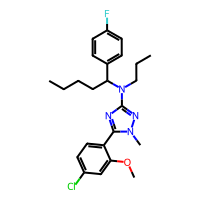
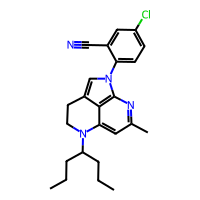
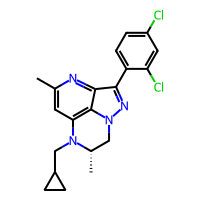
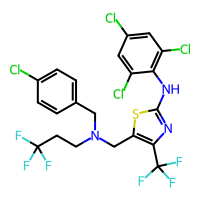

In [63]:
ds1 = catalog['CHEMBL1800-1'].read()
ds1.head()

That's a pandas data frame

## Aside: you can also load the data directly from github

This is a bit slower since everything has to come across the network:

In [64]:
import intake
catalog2 = intake.open_catalog('https://raw.githubusercontent.com/rinikerlab/molecular_time_series/main/datasets/chemblKi_SIMPD.yaml')
catalog2.metadata

{'version': 1,
 'creator': {'name': 'greg landrum', 'email': 'glandrum@ethz.ch'},
 'summary': "Collection of datasets with pchembl_values for bioactivity prediction.\n\nEach row includes the reported value. Only values without data_validity_comments are included\nActive/inactive class assignments were done to give a 40/60 inactive/active ratio\nThe suggested train/test split was created using the SIMPD algorithm\nAll compounds have been salt stripped and neutralized using the RDKit's ChargeParent standardizer\n",
 'split_column': 'split',
 'class_column': 'active',
 'activity_column': 'standard_value'}

# Generating fingerprints

More on this here:
https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html

In [66]:
import numpy as np
from rdkit.Chem import rdFingerprintGenerator

fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fps = np.array([fpgen.GetFingerprintAsNumPy(m) for m in ds1.mol])
len(fps)

518

Quick demo on using those to build a model:

In [67]:
train = ds1.split=='train'

train_fps = fps[train]
test_fps = fps[~train]

train_acts = np.array(ds1.active[train])
test_acts = np.array(ds1.active[~train])

len(train_fps)

415

In [68]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

cls = RandomForestClassifier(n_estimators=300,n_jobs=4,max_depth=10)
cls.fit(train_fps,train_acts)

probs = cls.predict_proba(test_fps)
preds = [1 if x[1]>0.5 else 0 for x in probs]
print(metrics.confusion_matrix(preds,test_acts))
auroc = metrics.roc_auc_score(test_acts,[y for x,y in probs])
print(auroc)
fpr,tpr,thresholds = metrics.roc_curve(test_acts,[y for x,y in probs],pos_label=1)

[[55 15]
 [ 2 31]]
0.9126620900076278


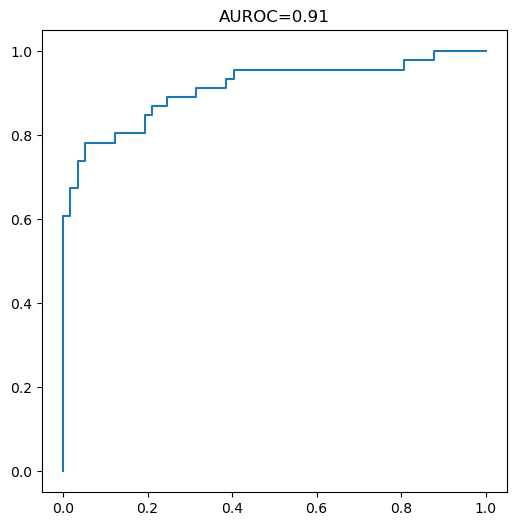

In [69]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr);
plt.title(f'AUROC={auroc:.2f}');

## Tools for explaining models/model predictions

Plotting feature importances:

In [70]:
importances = cls.feature_importances_
most_important = np.argsort(importances)[-10:]
np.take(importances,most_important)

array([0.0076407 , 0.00787657, 0.0085313 , 0.0086087 , 0.00884105,
       0.00966367, 0.00974844, 0.01077406, 0.01211506, 0.01809559])

Bit index of the most important feature

In [71]:
most_important[-1]

180

Find an active molecule that has that bit set:

In [72]:
actives_with_bit = [i for i,(fp,act) in enumerate(zip(fps,ds1.active)) if act and fp[most_important[-1]]]
len(actives_with_bit)

32

In [73]:
mol = ds1.mol[actives_with_bit[0]]
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()
fp = fpgen.GetFingerprint(mol,additionalOutput=ao)
bit_info = ao.GetBitInfoMap()
bit_info[most_important[-1]]

((5, 2),)

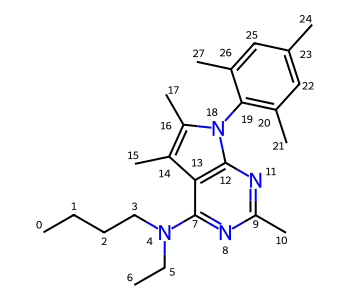

In [76]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = (350,300)
mol

In [77]:
IPythonConsole.drawOptions.addAtomIndices = False

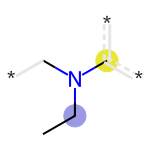

In [78]:
Draw.DrawMorganBit(mol,most_important[-1],bit_info)

In [79]:
bits_there = [k for k in most_important if k in bit_info]
bits_there

[180]

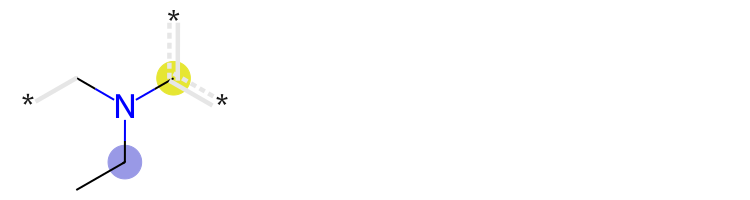

In [80]:
tpls = [(mol,i,bit_info) for i in bits_there]
Draw.DrawMorganBits(tpls,subImgSize=(250,200))

We can also use a similarity map to visualize which atoms were important for a prediction

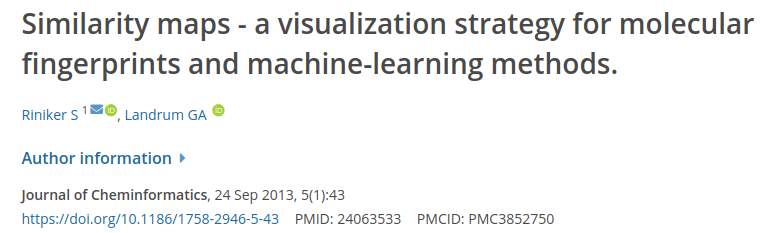
https://doi.org/10.1186/1758-2946-5-43


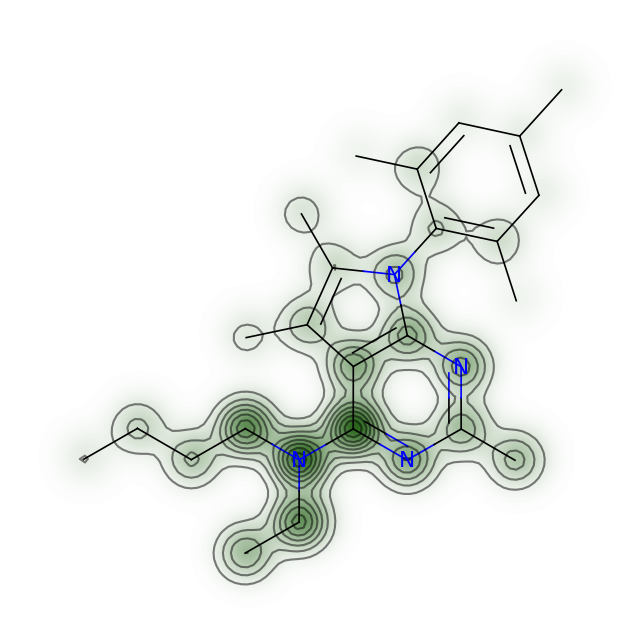

In [81]:
from rdkit.Chem.Draw import SimilarityMaps
tpl = SimilarityMaps.GetSimilarityMapForModel(mol,lambda x,y:[SimilarityMaps.GetMorganFingerprint(x,y,radius=2,nBits=2048)],
                                              lambda x:cls.predict_proba(x)[0][1])

# Standardizing molecules

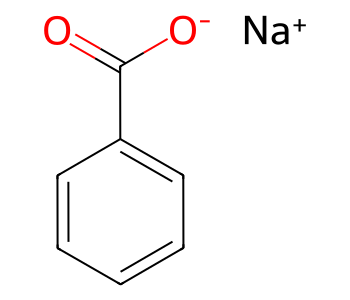

In [97]:
m = Chem.MolFromSmiles('c1ccccc1C(=O)[O-].[Na+]')
m

[10:12:54] Initializing MetalDisconnector
[10:12:54] Running MetalDisconnector
[10:12:54] Initializing Normalizer
[10:12:54] Running Normalizer
[10:12:54] Running LargestFragmentChooser
[10:12:54] Fragment: O=C([O-])c1ccccc1
[10:12:54] New largest fragment: O=C([O-])c1ccccc1 (14)
[10:12:54] Fragment: [Na+]


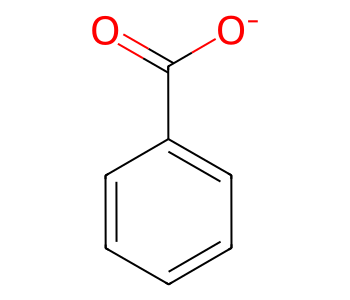

In [98]:
from rdkit.Chem.MolStandardize import rdMolStandardize
rdMolStandardize.FragmentParent(m)

[10:13:11] Initializing MetalDisconnector
[10:13:11] Running MetalDisconnector
[10:13:11] Initializing Normalizer
[10:13:11] Running Normalizer
[10:13:11] Running LargestFragmentChooser
[10:13:11] Fragment: O=C([O-])c1ccccc1
[10:13:11] New largest fragment: O=C([O-])c1ccccc1 (14)
[10:13:11] Fragment: [Na+]
[10:13:11] Running Uncharger
[10:13:11] Removed negative charge.
[10:13:11] Initializing MetalDisconnector
[10:13:11] Running MetalDisconnector
[10:13:11] Initializing Normalizer
[10:13:11] Running Normalizer


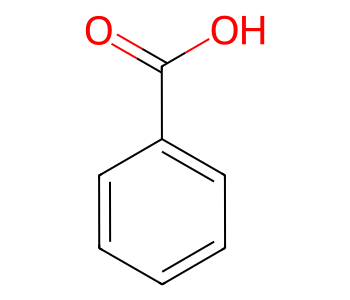

In [99]:
rdMolStandardize.ChargeParent(m)

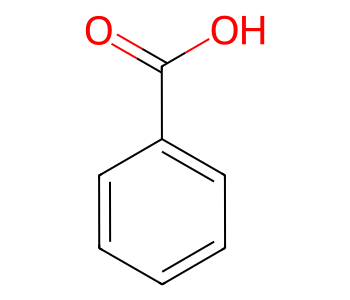

In [100]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')
rdMolStandardize.ChargeParent(m)

More info about the standardizer:
  - https://greglandrum.github.io/rdkit-blog/posts/2024-02-11-more-multithreading.html
  - https://greglandrum.github.io/rdkit-blog/posts/2024-02-23-custom-transformations-and-logging.html


# Filtering molecules by substructure

In [82]:
from rdkit.Chem import FunctionalGroups
_ = FunctionalGroups.BuildFuncGroupHierarchy()
FunctionalGroups.groupDefns.keys()

dict_keys(['AcidChloride', 'AcidChloride.Aromatic', 'AcidChloride.Aliphatic', 'CarboxylicAcid', 'CarboxylicAcid.Aromatic', 'CarboxylicAcid.Aliphatic', 'CarboxylicAcid.AlphaAmino', 'SulfonylChloride', 'SulfonylChloride.Aromatic', 'SulfonylChloride.Aliphatic', 'Amine', 'Amine.Primary', 'Amine.Primary.Aromatic', 'Amine.Primary.Aliphatic', 'Amine.Secondary', 'Amine.Secondary.Aromatic', 'Amine.Secondary.Aliphatic', 'Amine.Tertiary', 'Amine.Tertiary.Aromatic', 'Amine.Tertiary.Aliphatic', 'Amine.Aromatic', 'Amine.Aliphatic', 'Amine.Cyclic', 'BoronicAcid', 'BoronicAcid.Aromatic', 'BoronicAcid.Aliphatic', 'Isocyanate', 'Isocyanate.Aromatic', 'Isocyanate.Aliphatic', 'Alcohol', 'Alcohol.Aromatic', 'Alcohol.Aliphatic', 'Aldehyde', 'Aldehyde.Aromatic', 'Aldehyde.Aliphatic', 'Halogen', 'Halogen.Aromatic', 'Halogen.Aliphatic', 'Halogen.NotFluorine', 'Halogen.NotFluorine.Aliphatic', 'Halogen.NotFluorine.Aromatic', 'Halogen.Bromine', 'Halogen.Bromine.Aliphatic', 'Halogen.Bromine.Aromatic', 'Halogen.Bro

In [83]:
from rdkit.Chem import rdfiltercatalog
fgs = {}
for fg in FunctionalGroups.groupDefns.keys():
    matcher = rdfiltercatalog.SmartsMatcher(fg,FunctionalGroups.groupDefns[fg].smarts,1,1)   
    fgs[fg] = matcher

In [84]:
amines = [m for m in bbs if fgs['Amine.Primary'].HasMatch(m)]
len(amines)

1687

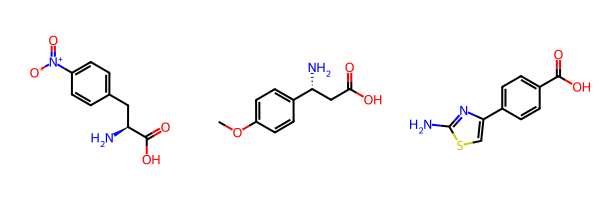

In [85]:
Draw.MolsToGridImage(amines[:3])

1513


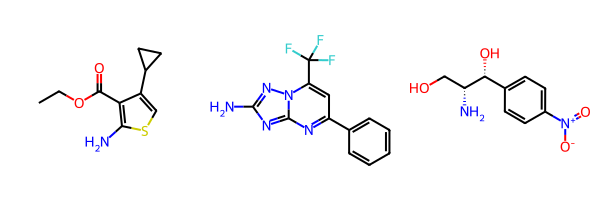

In [86]:
amines = [m for m in amines if not fgs['CarboxylicAcid'].HasMatch(m) and not fgs['AcidChloride'].HasMatch(m)]
print(len(amines))
Draw.MolsToGridImage(amines[:3])

In [87]:
acids = [m for m in bbs if fgs['CarboxylicAcid.Aromatic'].HasMatch(m)] + [m for m in bbs if fgs['AcidChloride.Aromatic'].HasMatch(m)]
acids = [m for m in acids if not fgs['Amine'].HasMatch(m)]
len(acids)

697

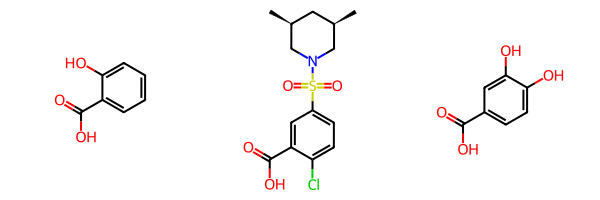

In [88]:
Draw.MolsToGridImage(acids[:3])

It's also possible to filter molecules using simple SMILES or SMARTS matching:

1


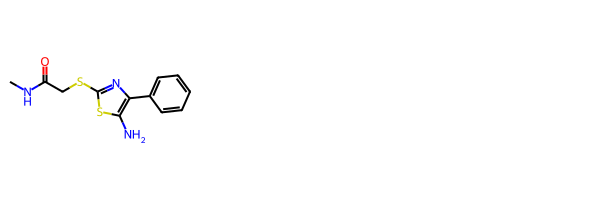

In [89]:
qry = Chem.MolFromSmiles('Nc1scnc1')
tmp = [m for m in amines if m.HasSubstructMatch(qry)]
print(len(tmp))
Draw.MolsToGridImage(tmp[:3])

41


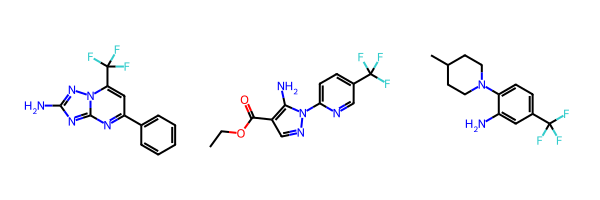

In [90]:
qry = Chem.MolFromSmarts('cC(F)(F)F')
tmp = [m for m in amines if m.HasSubstructMatch(qry)]
print(len(tmp))
Draw.MolsToGridImage(tmp[:3])

# Chemical reactions

## Transformations

### Modeling real reactions

In [50]:
from rdkit.Chem import rdChemReactions

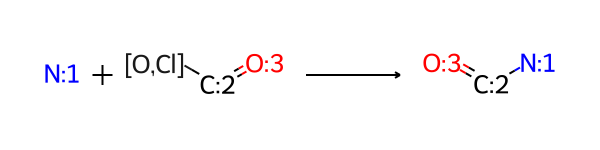

In [51]:
reaction = rdChemReactions.ReactionFromSmarts('[NH2:1].[C:2](=[O:3])-[O,Cl]>>[N:1]-[C:2]=[O:3]')
reaction

In [52]:
ps = reaction.RunReactants((amines[0],acids[0]))
ps

((<rdkit.Chem.rdchem.Mol at 0x7f65d2b64510>,),)

Products of reactions are not sanitized, so we need to take care of that:

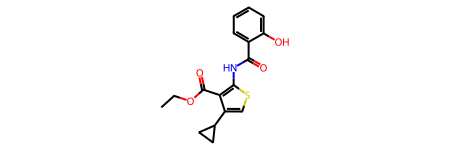

In [53]:
prod = ps[0][0]
Chem.SanitizeMol(prod)
prod

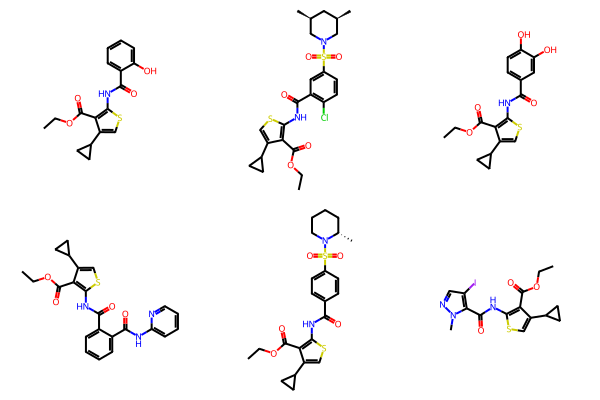

In [54]:
import itertools
all_pairs = itertools.product(amines,acids)
mols = []
for a,b in all_pairs:
    prods = reaction.RunReactants((a,b))
    if not prods:
        continue
    prod = prods[0][0]
    Chem.SanitizeMol(prod)
    mols.append(prod)
    if len(mols)>=100:
        break
Draw.MolsToGridImage(mols[:6])

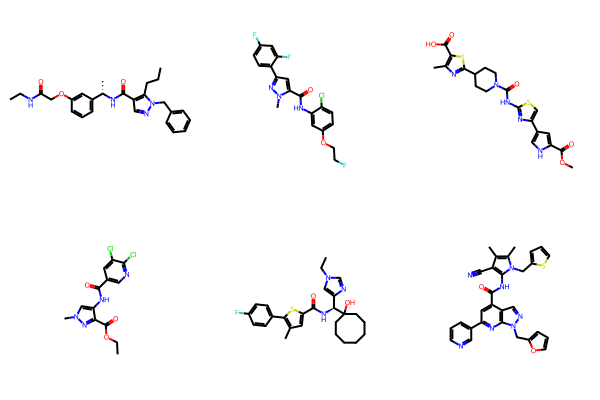

In [55]:
import itertools,random
all_pairs = list(itertools.product(range(len(amines)),range(len(acids))))
random.seed(0xf00d)
random.shuffle(all_pairs)
mols = []
for a,b in all_pairs:
    prods = reaction.RunReactants((amines[a],acids[b]))
    if not prods:
        continue
    prod = prods[0][0]
    Chem.SanitizeMol(prod)
    mols.append(prod)
    if len(mols)>=100:
        break
Draw.MolsToGridImage(mols[:6])

### Doing pseudo-chemistry: attaching molecules to templates

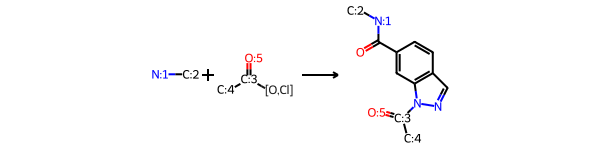

In [56]:
reaction2 = rdChemReactions.ReactionFromRxnFile('./data/pseudo_chemistry.rxn')
reaction2

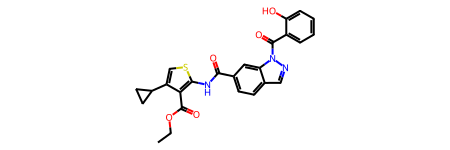

In [57]:
ps = reaction2.RunReactants((amines[0],acids[0]))
prod = ps[0][0]
Chem.SanitizeMol(prod)
prod

## Working with actual reactions

I'm using the SI from this paper:

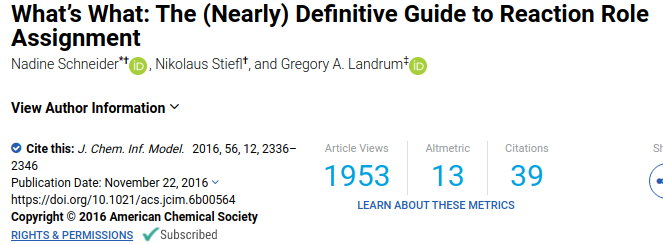

https://doi.org/10.1021/acs.jcim.6b00564

In [58]:
import pandas as pd
import numpy as np
df = pd.read_csv('./data/ci6b00564_si_datasetA.csv.gz')
df.head()

,rxn_Class,patentID,rxn_Smiles,reactantSet
0,1,US07678803B2,[H-].[CH3:1][c:2]1[cH:3][nH:4][c:5]2[c:6]1[C:7...,"set([1, 3])"
1,10,US07071180B2,CC(=O)O.[cH:5]1[cH:4][n:3][c:2]([c:7]([n:6]1)[...,"set([1, 6])"
2,1,US20130079342A1,CC(C)(C)[O-].CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CC...,"set([5, 13])"
3,2,US20140171403A1,[cH:25]1[c:24]([cH:31][c:29]([cH:28][c:26]1[Cl...,"set([0, 1])"
4,9,US07285563B2,CCCC[N+](CCCC)(CCCC)CCCC.CN(C)C=O.[cH:5]1[cH:6...,"set([2, 5])"


In [59]:
smis = df.rxn_Smiles.to_list()
smis[:3]

['[H-].[CH3:1][c:2]1[cH:3][nH:4][c:5]2[c:6]1[C:7](=[O:8])[CH2:9][C:10]([CH2:13]2)([CH3:11])[CH3:12].CN(C)C=O.[cH:23]1[cH:24][c:25]2[c:20]([cH:21][c:22]1F)[c:18]([cH:17][n:16][c:15]2[NH2:14])[Br:19].[NH4+].[Na+].[Cl-]>>[CH3:1][c:2]1[cH:3][n:4]([c:5]2[c:6]1[C:7](=[O:8])[CH2:9][C:10]([CH2:13]2)([CH3:11])[CH3:12])[c:22]3[cH:23][cH:24][c:25]4[c:20]([cH:21]3)[c:18]([cH:17][n:16][c:15]4[NH2:14])[Br:19]',
 'CC(=O)O.[cH:5]1[cH:4][n:3][c:2]([c:7]([n:6]1)[N:8]2[CH2:9][CH2:10][NH:11][CH2:12][CH2:13]2)[Cl:1].C(=O)([O-])[O-].O.[Na+].[Na+].Br[Br:13]>>[cH:5]1[c:4]([n:3][c:2]([c:7]([n:6]1)[N:8]2[CH2:9][CH2:10][NH:11][CH2:12][CH2:13]2)[Cl:1])[Br:13]',
 'CC(C)(C)[O-].CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1.CC(C)c1ccc(-c2ccccc2)c(C(C)C)c1C(C)C.CCO.Cc1ccccc1.Cl[c:7]1[c:2]([CH3:1])[c:3](-[c:13]2[n:14][cH:15][cH:16][cH:17][cH:18]2)[n:4][c:5]2[c:6]1[c:8]([F:12])[cH:9][cH:10][cH:11]2.O.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.O=C(/C=C/c1ccccc1)/C=C/c1ccccc1.[Na+].[Pd].[

In [60]:
smis = []
smis_no_agents = []
for smi,ris in zip(df.rxn_Smiles,df.reactantSet):
    ris = [int(x) for x in ris.replace('set([','').replace('])','').split(',')]
    trs,prods = smi.split('>>')
    trs = np.array(trs.split('.'))
    indices = np.zeros(len(trs),bool)
    for ri in ris:
        indices[ri]=1
    reacts = trs[indices]
    agents = trs[~indices]
    smi = f"{'.'.join(reacts)}>{'.'.join(agents)}>{prods}"
    smis.append(smi)
    smi = f"{'.'.join(reacts)}>>{prods}"
    smis_no_agents.append(smi)

In [61]:
smis[0]

'[CH3:1][c:2]1[cH:3][nH:4][c:5]2[c:6]1[C:7](=[O:8])[CH2:9][C:10]([CH2:13]2)([CH3:11])[CH3:12].[cH:23]1[cH:24][c:25]2[c:20]([cH:21][c:22]1F)[c:18]([cH:17][n:16][c:15]2[NH2:14])[Br:19]>[H-].CN(C)C=O.[NH4+].[Na+].[Cl-]>[CH3:1][c:2]1[cH:3][n:4]([c:5]2[c:6]1[C:7](=[O:8])[CH2:9][C:10]([CH2:13]2)([CH3:11])[CH3:12])[c:22]3[cH:23][cH:24][c:25]4[c:20]([cH:21]3)[c:18]([cH:17][n:16][c:15]4[NH2:14])[Br:19]'

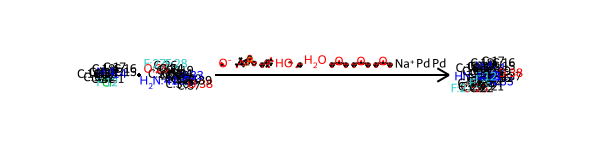

In [62]:
rxn = rdChemReactions.ReactionFromSmarts(smis[2],useSmiles=True)
rxn

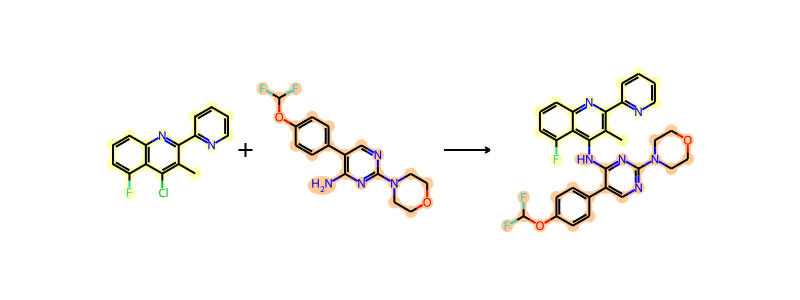

In [79]:
IPythonConsole.highlightByReactant = True
IPythonConsole.molSize=600,300
rxn = rdChemReactions.ReactionFromSmarts(smis_no_agents[2],useSmiles=True)
rxn

Looking at the reactions can really help identify problems:

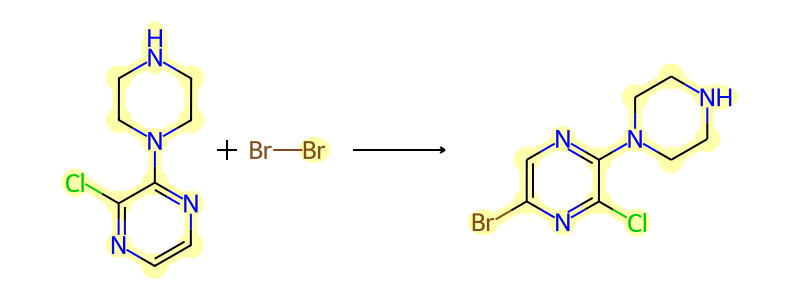

In [80]:
rdChemReactions.ReactionFromSmarts(smis_no_agents[1],useSmiles=True)

In [81]:
smis_no_agents[1]

'[cH:5]1[cH:4][n:3][c:2]([c:7]([n:6]1)[N:8]2[CH2:9][CH2:10][NH:11][CH2:12][CH2:13]2)[Cl:1].Br[Br:13]>>[cH:5]1[c:4]([n:3][c:2]([c:7]([n:6]1)[N:8]2[CH2:9][CH2:10][NH:11][CH2:12][CH2:13]2)[Cl:1])[Br:13]'

Let's look at what's changing in the reaction

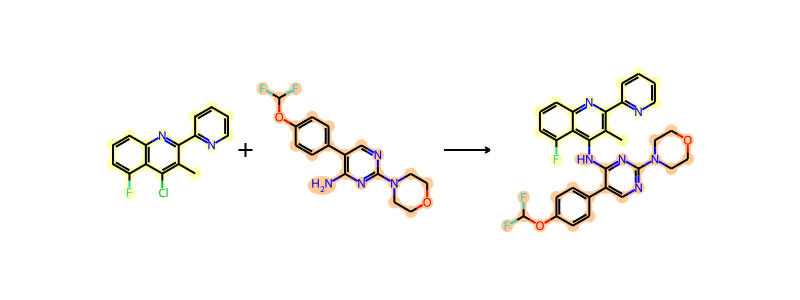

In [82]:
rxn = rdChemReactions.ReactionFromSmarts(smis_no_agents[2],useSmiles=True)
rxn

In [83]:
rxn.Initialize()
rxn.GetReactingAtoms()

((0, 1), (4,))

In [84]:
for reactant in rxn.GetReactants():
    for atom in reactant.GetAtoms():
        atom.SetAtomMapNum(0)
for product in rxn.GetProducts():
    for atom in product.GetAtoms():
        atom.SetAtomMapNum(0)
    

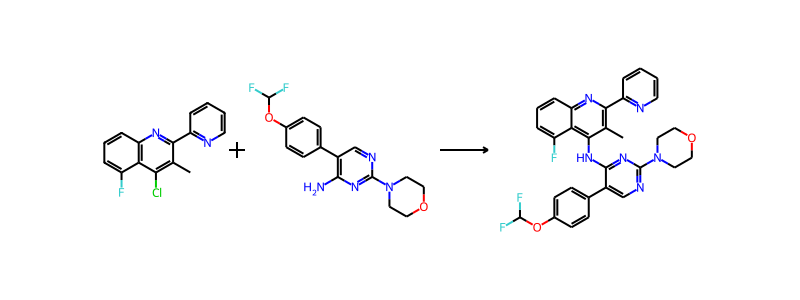

In [85]:
IPythonConsole.highlightByReactant=False
rxn

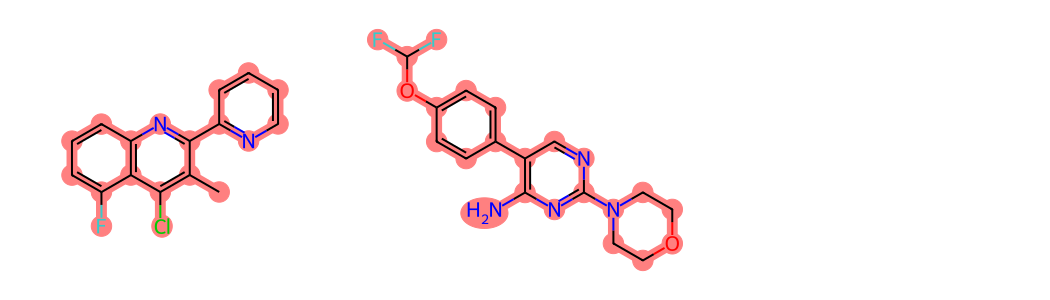

In [74]:
reacts = []
for react in rxn.GetReactants():
    react = Chem.Mol(react)
    Chem.SanitizeMol(react)
    reacts.append(react)
    
Draw.MolsToGridImage(reacts,subImgSize=(350,300),highlightAtomLists=rxn.GetReactingAtoms())

In [75]:
from ipywidgets import interact,fixed
@interact(smis=fixed(smis_no_agents),idx=range(len(smis_no_agents)))
def show_rxn(idx,smis):
    rxn = rdChemReactions.ReactionFromSmarts(smis[idx],useSmiles=True)
    rxn.Initialize()
    if not rxn:
        return None
    reacts = []
    for react in rxn.GetReactants():
        react = Chem.Mol(react)
        Chem.SanitizeMol(react)
        reacts.append(react)
    return Draw.MolsToGridImage(reacts,subImgSize=(350,300),highlightAtomLists=rxn.GetReactingAtoms())

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

### Bonus advanced content

Highlighting the bonds which change in a reaction

In [76]:
from collections import namedtuple
AtomInfo = namedtuple('AtomInfo',('mapnum','reactant','reactantAtom','product','productAtom'))
def map_reacting_atoms_to_products(rxn,reactingAtoms):
    res = []
    for ridx,reacting in enumerate(reactingAtoms):
        reactant = rxn.GetReactantTemplate(ridx)
        for raidx in reacting:
            mapnum = reactant.GetAtomWithIdx(raidx).GetAtomMapNum()
            foundit=False
            for pidx,product in enumerate(rxn.GetProducts()):
                for paidx,patom in enumerate(product.GetAtoms()):
                    if patom.GetAtomMapNum()==mapnum:
                        res.append(AtomInfo(mapnum,ridx,raidx,pidx,paidx))
                        foundit = True
                        break
                    if foundit:
                        break
    return res
def get_mapped_neighbors(atom):
    res = {}
    amap = atom.GetAtomMapNum()
    if not amap:
        return res
    for nbr in atom.GetNeighbors():
        nmap = nbr.GetAtomMapNum()
        if nmap:
            if amap>nmap:
                res[(nmap,amap)] = (atom.GetIdx(),nbr.GetIdx())
            else:
                res[(amap,nmap)] = (nbr.GetIdx(),atom.GetIdx())
    return res

BondInfo = namedtuple('BondInfo',('product','productAtoms','productBond','status'))
def find_modified_bonds_in_products(rxn):
    rxn.Initialize()
    reactingAtoms = rxn.GetReactingAtoms()
    amap = map_reacting_atoms_to_products(rxn,reactingAtoms)
    res = []
    seen = set()
    for _,ridx,raidx,pidx,paidx in amap:
        reactant = rxn.GetReactantTemplate(ridx)
        ratom = reactant.GetAtomWithIdx(raidx)
        product = rxn.GetProductTemplate(pidx)
        patom = product.GetAtomWithIdx(paidx)

        rnbrs = get_mapped_neighbors(ratom)
        pnbrs = get_mapped_neighbors(patom)
        for tpl in pnbrs:
            pbond = product.GetBondBetweenAtoms(*pnbrs[tpl])
            if (pidx,pbond.GetIdx()) in seen:
                continue
            seen.add((pidx,pbond.GetIdx()))
            if not tpl in rnbrs:
                # new bond in product
                res.append(BondInfo(pidx,pnbrs[tpl],pbond.GetIdx(),'New'))
            else:
                # present in both reactants and products, check to see if it changed
                rbond = reactant.GetBondBetweenAtoms(*rnbrs[tpl])
                if rbond.GetBondType()!=pbond.GetBondType():
                    res.append(BondInfo(pidx,pnbrs[tpl],pbond.GetIdx(),'Changed'))
    return res


from IPython.display import Image
def draw_product_with_modified_bonds(rxn,pidx,bnds,showAtomMaps=False):
    d2d = Draw.rdMolDraw2D.MolDraw2DCairo(350,300)
    pmol = Chem.Mol(rxn.GetProductTemplate(pidx))
    Chem.SanitizeMol(pmol)
    if not showAtomMaps:
        for atom in pmol.GetAtoms():
            atom.SetAtomMapNum(0)
    bonds_to_highlight=[]
    highlight_bond_colors={}
    atoms_to_highlight=set()
    for binfo in bnds:
        if binfo.product==pidx and binfo.status=='New':
            bonds_to_highlight.append(binfo.productBond)
            highlight_bond_colors[binfo.productBond] = (1,.4,.4)
        if binfo.product==pidx and binfo.status=='Changed':
            bonds_to_highlight.append(binfo.productBond)
            highlight_bond_colors[binfo.productBond] = (.4,.4,1)
    d2d.drawOptions().useBWAtomPalette()
    d2d.DrawMolecule(pmol,highlightAtoms=atoms_to_highlight,highlightBonds=bonds_to_highlight,
                     highlightBondColors=highlight_bond_colors)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()



In [91]:
rxn = rdChemReactions.ReactionFromSmarts(smis[2],useSmiles=True)
rxn.Initialize()
bnds = find_modified_bonds_in_products(rxn)
bnds

[BondInfo(product=0, productAtoms=(13, 12), productBond=12, status='New')]

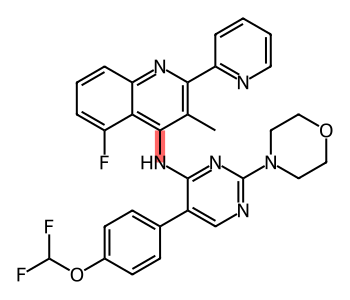

In [92]:
Image(draw_product_with_modified_bonds(rxn,0,bnds))

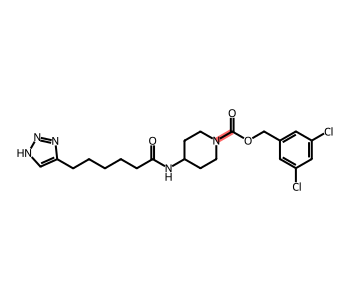

In [90]:
rxn = rdChemReactions.ReactionFromSmarts(smis_no_agents[3],useSmiles=True)
bnds = find_modified_bonds_in_products(rxn)
Image(draw_product_with_modified_bonds(rxn,0,bnds))

In [89]:
from ipywidgets import interact,fixed
@interact(smis=fixed(smis_no_agents),idx=range(len(smis_no_agents)))
def show_rxn(idx,smis):
    rxn = rdChemReactions.ReactionFromSmarts(smis[idx],useSmiles=True)
    if not rxn:
        return None
    bnds = find_modified_bonds_in_products(rxn)
    return Image(draw_product_with_modified_bonds(rxn,0,bnds))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [94]:
from ipywidgets import interact,fixed
@interact(smis=fixed(smis_no_agents),idx=range(len(smis_no_agents)))
def show_rxn(idx,smis):
    rxn = rdChemReactions.ReactionFromSmarts(smis[idx],useSmiles=True)
    if not rxn:
        return None
    for reactant in rxn.GetReactants():
        for atom in reactant.GetAtoms():
            atom.SetAtomMapNum(0)
    for product in rxn.GetProducts():
        for atom in product.GetAtoms():
            atom.SetAtomMapNum(0)
    return Image(IPythonConsole._toReactionPNG(rxn))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…